In [ ]:
### START HERE ###

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import h5py

class CryoData(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5_file
        with h5py.File(self.h5_file, 'r') as file:
            self.keys = list(file.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as file:
            group = file[self.keys[idx]]
            true_ca = torch.tensor(group['true_ca'][:])
            homolog_ca = torch.tensor(group['homolog_ca'][:])
            true_vol = torch.tensor(group['true_vol'][:])
        return {'true_ca': true_ca, 'homolog_ca': homolog_ca, 'true_vol': true_vol}

# Usage example
dataset = CryoData('./data/cryo_data_rmsd.h5')

# Assuming you have a CryoData instance called 'dataset'
for i in range(2):  # Check the first three samples
    sample = dataset[i]
    print(f"Sample {i}:")
    print(f"homolog_ca shape: {sample['homolog_ca'].shape}")
    print(f"true_vol shape: {sample['true_vol'].shape}")
    print(f"true_ca shape: {sample['true_ca'].shape}")
    print(f"homolog_ca stats: min={sample['homolog_ca'].min()}, max={sample['homolog_ca'].max()}")
    print(f"true_vol stats: min={sample['true_vol'].min()}, max={sample['true_vol'].max()}")
    print(f"true_ca stats: min={sample['true_ca'].min()}, max={sample['true_ca'].max()}")
    print()


Sample 0:
homolog_ca shape: torch.Size([64, 64, 64])
true_vol shape: torch.Size([64, 64, 64])
true_ca shape: torch.Size([64, 64, 64])
homolog_ca stats: min=0.0, max=1.0
true_vol stats: min=0.0, max=1.0
true_ca stats: min=0.0, max=1.0

Sample 1:
homolog_ca shape: torch.Size([64, 64, 64])
true_vol shape: torch.Size([64, 64, 64])
true_ca shape: torch.Size([64, 64, 64])
homolog_ca stats: min=0.0, max=1.0
true_vol stats: min=0.0, max=1.0
true_ca stats: min=0.0, max=1.0



Batch homolog_ca shape: torch.Size([1, 64, 64, 64])
Batch true_vol shape: torch.Size([1, 64, 64, 64])
Batch true_ca shape: torch.Size([1, 64, 64, 64])
----------------------------------------------
Number of training cases: 230
Number of test cases: 26
---------------------------------
Training Data:
Avg FSC Loss (1-FSC): 0.6896
Min/Max FSC Loss: 0.0035, 0.9738
Avg RMSD: 0.0231
Min/Max RMSD: 0.0000, 0.0625
---------------------------------
Test Data
Avg FSC Loss (1-FSC): 0.6886
Min/Max FSC Loss: 0.0230, 0.9562
Avg RMSD: 0.0238
Min/Max RMSD: 0.0000, 0.0442


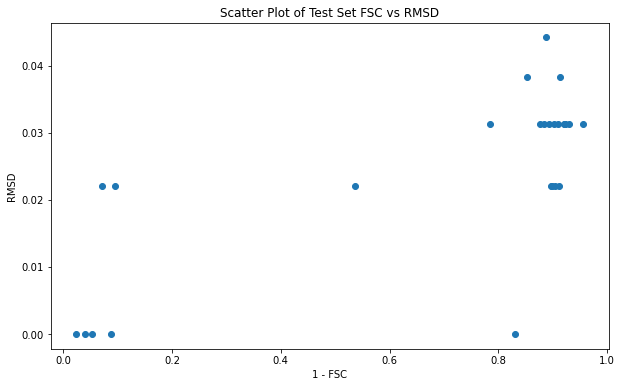

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from loss_utils import check_distributions
import matplotlib.pyplot as plt
import numpy as np

dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)  # 90% for training
test_size = dataset_size - train_size  # 10% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders for both train and test sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for batch in train_loader:
    print(f"Batch homolog_ca shape: {batch['homolog_ca'].shape}")
    print(f"Batch true_vol shape: {batch['true_vol'].shape}")
    print(f"Batch true_ca shape: {batch['true_ca'].shape}")
    break;

train_fsc, train_rmsd, test_fsc, test_rmsd = check_distributions(train_loader, test_loader)
    
print('----------------------------------------------')
print(f'Number of training cases: {len(train_fsc)}')
print(f'Number of test cases: {len(test_fsc)}')
print('---------------------------------')
print('Training Data:')
print(f'Avg FSC Loss (1-FSC): {np.array(train_fsc).mean():.4f}')
print(f'Min/Max FSC Loss: {np.array(train_fsc).min():.4f}, {np.array(train_fsc).max():.4f}')
print(f'Avg RMSD: {np.array(train_rmsd).mean():.4f}')
print(f'Min/Max RMSD: {np.array(train_rmsd).min():.4f}, {np.array(train_rmsd).max():.4f}')
print('---------------------------------')
print('Test Data')
print(f'Avg FSC Loss (1-FSC): {np.array(test_fsc).mean():.4f}')
print(f'Min/Max FSC Loss: {np.array(test_fsc).min():.4f}, {np.array(test_fsc).max():.4f}')
print(f'Avg RMSD: {np.array(test_rmsd).mean():.4f}')
print(f'Min/Max RMSD: {np.array(test_rmsd).min():.4f}, {np.array(test_rmsd).max():.4f}')

'''
# Create a histogram for FSC and RMSD
plt.figure(figsize=(10, 6))
plt.hist(test_fsc, bins=26, alpha=0.7)
plt.title('Histogram of Test Set FSC')
plt.xlabel('1 - FSC')  
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(test_rmsd, bins=26, alpha=0.7)
plt.title('Histogram of Test Set RMSD') 
plt.xlabel('RMSD')  
plt.ylabel('Frequency') 
plt.show()
'''

plt.figure(figsize=(10, 6))
plt.scatter(test_fsc, test_rmsd)
plt.title('Scatter Plot of Test Set FSC vs RMSD') 
plt.xlabel('1 - FSC')  
plt.ylabel('RMSD') 
plt.show()

In [6]:
# Load model from unet_model.py
from unet_model import UNet
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = UNet().to(device)

Using device: cuda


In [7]:
from torchsummary import summary

# Print the model summary
summary(model, (2, 64, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 64, 64, 64]           3,520
              ReLU-2       [-1, 64, 64, 64, 64]               0
       BatchNorm3d-3       [-1, 64, 64, 64, 64]             128
            Conv3d-4       [-1, 64, 64, 64, 64]         110,656
              ReLU-5       [-1, 64, 64, 64, 64]               0
       BatchNorm3d-6       [-1, 64, 64, 64, 64]             128
            Conv3d-7      [-1, 128, 32, 32, 32]         221,312
              ReLU-8      [-1, 128, 32, 32, 32]               0
       BatchNorm3d-9      [-1, 128, 32, 32, 32]             256
           Conv3d-10      [-1, 128, 32, 32, 32]         442,496
             ReLU-11      [-1, 128, 32, 32, 32]               0
      BatchNorm3d-12      [-1, 128, 32, 32, 32]             256
           Conv3d-13      [-1, 256, 16, 16, 16]         884,992
             ReLU-14      [-1, 256, 16,

In [8]:
# Import the loss functions from loss_utils.py
from loss_utils import fsc_loss_function, rmsd_loss_function, cosine_similarity_loss_function
import torch
#import torch.nn.functional as F
    
def combined_loss_function(prediction, target, combination=0, alpha=1, beta=1, gamma=1):
    if combination == 1:
        fsc_loss = fsc_loss_function(prediction, target)
        rmsd_loss = rmsd_loss_function(prediction, target)
        cs_loss = cosine_similarity_loss_function(prediction, target)
        total_loss = alpha * fsc_loss + beta * rmsd_loss + gamma * cs_loss
        return total_loss, fsc_loss, rmsd_loss, cs_loss
    else:
        fsc_loss = fsc_loss_function(prediction, target)
        rmsd_loss = rmsd_loss_function(prediction, target)
        total_loss = alpha * fsc_loss + beta * rmsd_loss 
        return total_loss, fsc_loss, rmsd_loss

In [9]:
### Keep optimizer and list of losses outside of the train cell to continue 
###                  training by re-running cell

num_epochs = 25
print(f"Number of Epochs to Run: {num_epochs}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

fsc_loss_train_values = []
rmsd_loss_train_values = []
combined_loss_values = []
cs_loss_values = []

Number of Epochs to Run: 25


In [10]:
import numpy as np
import torch
from tqdm import tqdm  

# Training loop
for epoch in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for i, batch in enumerate(train_loader):
            homolog_ca = batch['homolog_ca'].to(device)
            true_vol = batch['true_vol'].to(device)
            true_ca = batch['true_ca'].to(device)
    
            # Stack the arrays along a new dimension to create a tensor of shape 2x64x64x64
            inputs = torch.stack((homolog_ca, true_vol), dim=1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
    
            # Compute the predictions corresponding to the homolog_ca array
            homolog_ca_predictions = outputs[:, :1, :, :, :]
           
            combined_loss, fsc_loss_value, rmsd_loss = combined_loss_function(homolog_ca_predictions, true_ca.unsqueeze(1), combination=0)
            combined_loss.backward()
            optimizer.step()
    
            fsc_loss_train_values.append(fsc_loss_value.item())
            rmsd_loss_train_values.append(rmsd_loss.item())
            combined_loss_values.append(combined_loss.item())
            #cs_loss_values.append(cs_loss.item())
            
            # Log the training loss for every 23rd batch
            #if i % 1234 == 0:
                #print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}, FSC: {fsc_loss_value.item():.4f}, RMSD: {rmsd_loss.item():.4f}, Cos-Similarity: {cs_loss.item():.4f}, Total loss: {combined_loss.item():.4f}")

            # Update the progress bar
            pbar.set_postfix({'loss': combined_loss.item()})
            pbar.update(1)
                
        # Log for each epoch
        print(f"Finished Epoch #{epoch+1}")
        print(f"Average FSC: {np.array(fsc_loss_train_values).mean():.4f}")
        print(f"Average RMSD: {np.array(rmsd_loss_train_values).mean():.4f}")
        print(f"Combined Loss: {np.array(combined_loss_values).mean():.4f}")
    
        # Save training data
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': combined_loss,
        }, 'checkpoint_v2_50epochs.pth')
        

Epoch 1/25: 100%|██████████| 230/230 [01:27<00:00,  2.61it/s, loss=0.94] 

Finished Epoch #1
Average FSC: 0.7783
Average RMSD: 0.0376
Combined Loss: 0.8159


Epoch 2/25: 100%|██████████| 230/230 [01:28<00:00,  2.58it/s, loss=0.327]

Finished Epoch #2
Average FSC: 0.7534
Average RMSD: 0.0295
Combined Loss: 0.7829


Epoch 3/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.867]

Finished Epoch #3
Average FSC: 0.7388
Average RMSD: 0.0263
Combined Loss: 0.7652


Epoch 4/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.782]

Finished Epoch #4
Average FSC: 0.7294
Average RMSD: 0.0246
Combined Loss: 0.7540


Epoch 5/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.723]

Finished Epoch #5
Average FSC: 0.7213
Average RMSD: 0.0233
Combined Loss: 0.7446


Epoch 6/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.629]

Finished Epoch #6
Average FSC: 0.7141
Average RMSD: 0.0224
Combined Loss: 0.7365


Epoch 7/25: 100%|██████████| 230/230 [01:29<00:00,  2.55it/s, loss=0.194]

Finished Epoch #7
Average FSC: 0.7074
Average RMSD: 0.0217
Combined Loss: 0.7291


Epoch 8/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.863] 

Finished Epoch #8
Average FSC: 0.7015
Average RMSD: 0.0212
Combined Loss: 0.7227


Epoch 9/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.822] 

Finished Epoch #9
Average FSC: 0.6963
Average RMSD: 0.0207
Combined Loss: 0.7170


Epoch 11/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.837] 

Finished Epoch #11
Average FSC: 0.6838
Average RMSD: 0.0200
Combined Loss: 0.7038


Epoch 12/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.768] 

Finished Epoch #12
Average FSC: 0.6773
Average RMSD: 0.0196
Combined Loss: 0.6969


Epoch 13/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.736] 

Finished Epoch #13
Average FSC: 0.6715
Average RMSD: 0.0193
Combined Loss: 0.6908


Epoch 15/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.771] 

Finished Epoch #15
Average FSC: 0.6598
Average RMSD: 0.0187
Combined Loss: 0.6786


Epoch 16/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.655] 

Finished Epoch #16
Average FSC: 0.6540
Average RMSD: 0.0185
Combined Loss: 0.6725


Epoch 18/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.795] 

Finished Epoch #18
Average FSC: 0.6441
Average RMSD: 0.0181
Combined Loss: 0.6622


Epoch 19/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.073] 

Finished Epoch #19
Average FSC: 0.6390
Average RMSD: 0.0179
Combined Loss: 0.6569


Epoch 22/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.683] 

Finished Epoch #22
Average FSC: 0.6235
Average RMSD: 0.0174
Combined Loss: 0.6409


Epoch 23/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.094] 

Finished Epoch #23
Average FSC: 0.6180
Average RMSD: 0.0172
Combined Loss: 0.6353


Epoch 25/25: 100%|██████████| 230/230 [01:29<00:00,  2.57it/s, loss=0.618] 

Finished Epoch #25
Average FSC: 0.6074
Average RMSD: 0.0169
Combined Loss: 0.6243


Epoch 25/25: 100%|██████████| 230/230 [01:29<00:00,  2.56it/s, loss=0.618]


In [12]:
### CODE TO RELOAD FROM CHECKPOINT ###
#checkpoint = torch.load('checkpoint.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#start_epoch = checkpoint['epoch']
#loss = checkpoint['loss']


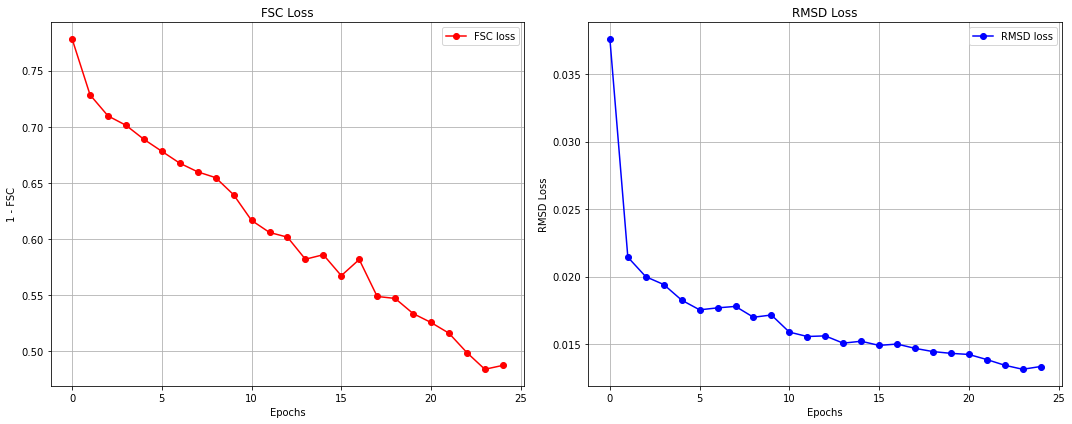

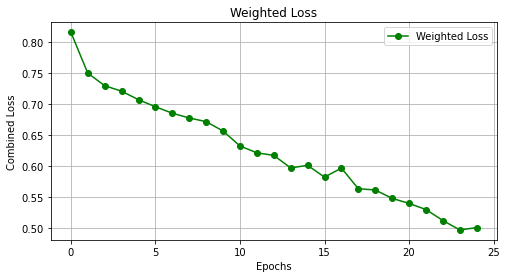

In [11]:
import matplotlib.pyplot as plt


def average_per_epoch(loss_array, batches_per_epoch):
    return np.array([np.mean(loss_array[i:i + batches_per_epoch]) for i in range(0, len(loss_array), batches_per_epoch)])

fsc_loss_avg = average_per_epoch(fsc_loss_train_values, 230)
rmsd_loss_avg = average_per_epoch(rmsd_loss_train_values, 230)
combo_loss_avg = average_per_epoch(combined_loss_values, 230)

# Creating the subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns of subplots
# Plotting FSC losses
ax[0].plot(fsc_loss_avg, label='FSC loss', marker='o', color='red')
ax[1].plot(rmsd_loss_avg, label='RMSD loss', marker='o', color='blue')
ax[0].set_title('FSC Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('1 - FSC')
ax[0].legend()
ax[0].grid(True)
ax[1].set_title('RMSD Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSD Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# Plotting Combined losses
plt.plot(combo_loss_avg, label='Weighted Loss', color='green', marker='o')
plt.title('Weighted Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import mrcfile
import torch
from postprocess import save_mrc, apply_gaussian_smoothing

# Set the model to evaluation mode
model.eval()

# Initialize lists to store inputs, ground truth, and predictions
inputs_list = []
predictions_list = []
ground_truth_list = []

fsc_values_test = []
fsc_values_before_test = []
rmsd_values_test = []
rmsd_values_before_test = []

# Iterate over the test data
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        homolog_ca = batch['homolog_ca'].to(device)
        true_vol = batch['true_vol'].to(device)
        true_ca = batch['true_ca'].to(device)

        before_fsc_loss_value = fsc_loss_function(homolog_ca.unsqueeze(1), true_ca.unsqueeze(1))
        before_rmsd_loss_value = rmsd_loss_function(homolog_ca.unsqueeze(1), true_ca.unsqueeze(1))
             
        inputs = torch.stack((homolog_ca, true_vol), dim=1)
        
        # Forward pass
        outputs = model(inputs)

        # Compute the predictions corresponding to the homolog_ca array
        homolog_ca_predictions = outputs[:, :1, :, :, :]

        # Save MRC Files
        save_mrc(apply_gaussian_smoothing(true_ca), f'output/true/true_{i+1}.mrc')
        save_mrc(apply_gaussian_smoothing(homolog_ca), f'output/homologs/homolog_{i+1}.mrc')
        save_mrc(apply_gaussian_smoothing(homolog_ca_predictions.squeeze()), f'output/predictions/prediction_{i+1}.mrc')
        
        fsc_loss_value = fsc_loss_function(homolog_ca_predictions, true_ca.unsqueeze(1))
        rmsd_loss_value = rmsd_loss_function(homolog_ca_predictions, true_ca.unsqueeze(1))
        
        # Append inputs, ground truth, and predictions to the lists
        inputs_list.append(inputs.cpu().numpy())
        predictions_list.append(outputs.cpu().numpy())
        ground_truth_list.append(true_ca.cpu().numpy())
        
        fsc_values_test.append(fsc_loss_value.item())
        fsc_values_before_test.append(before_fsc_loss_value.item())
        rmsd_values_test.append(rmsd_loss_value.item())
        rmsd_values_before_test.append(before_rmsd_loss_value.item())
        
# Convert lists to NumPy arrays
inputs_array = np.concatenate(inputs_list, axis=0)
predictions_array = np.concatenate(predictions_list, axis=0)
ground_truth_array = np.concatenate(ground_truth_list, axis=0)

print(f'Avg FSC of Test set before the model: {(np.array(fsc_values_before_test).mean()-1)/-1:.4f}')
print(f'Avg FSC of Test set after model: {(np.array(fsc_values_test).mean()-1)/-1:.4f}')
print(f'Avg RMSD of Test set before the model: {(np.array(rmsd_values_before_test).mean()-1)/-1:.4f}')
print(f'Avg RMSD of Test set after model: {(np.array(rmsd_values_test).mean()-1)/-1:.4f}')


Avg FSC of Test set before the model: 0.2899
Avg FSC of Test set after model: 0.3160
Avg RMSD of Test set before the model: 0.9751
Avg RMSD of Test set after model: 0.9785


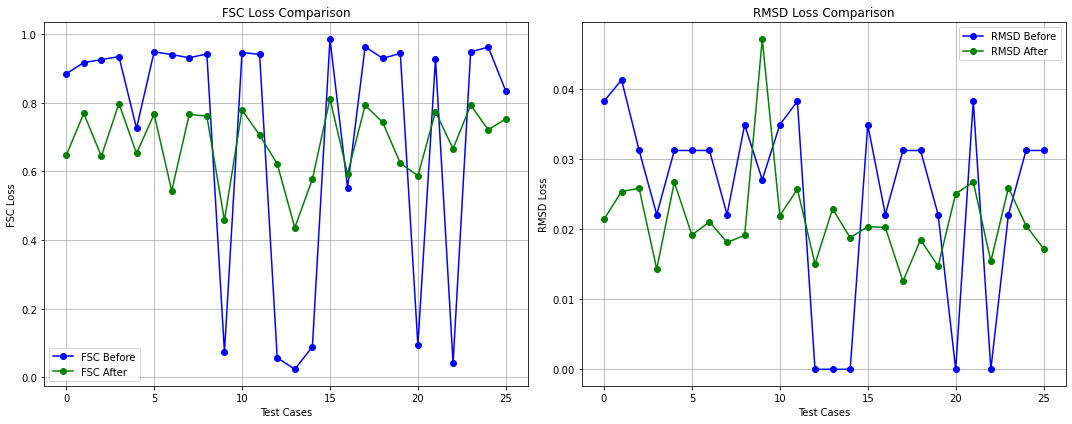

In [15]:
import matplotlib.pyplot as plt

# Creating the subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns of subplots

# Plotting FSC losses
ax[0].plot(fsc_values_before_test, label='FSC Before', marker='o', color='blue')
ax[0].plot(fsc_values_test, label='FSC After', marker='o', color='green')
ax[0].set_title('FSC Loss Comparison')
ax[0].set_xlabel('Test Cases')
ax[0].set_ylabel('FSC Loss')
ax[0].legend()
ax[0].grid(True)

# Plotting RMSD losses
ax[1].plot(rmsd_values_before_test, label='RMSD Before', color='blue', marker='o')
ax[1].plot(rmsd_values_test, label='RMSD After', color='green', marker='o')
ax[1].set_title('RMSD Loss Comparison')
ax[1].set_xlabel('Test Cases')
ax[1].set_ylabel('RMSD Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


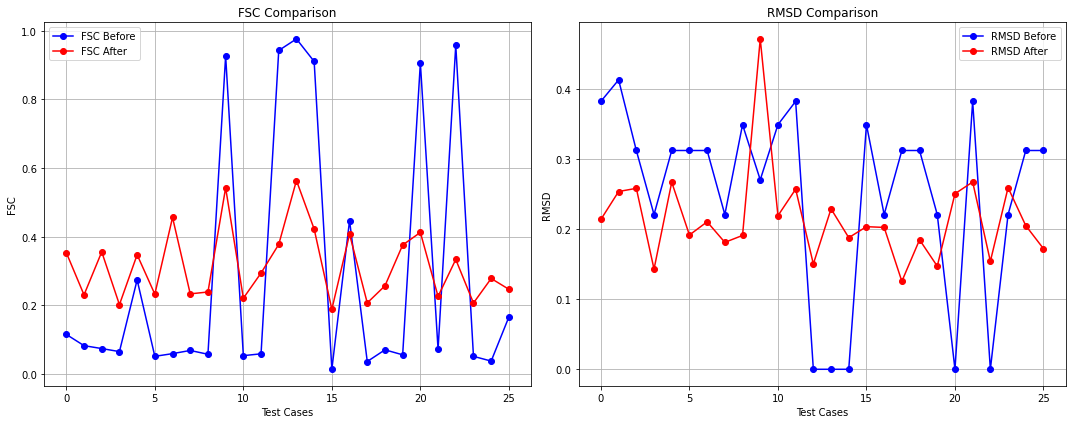

In [16]:
fsc_before_avg = [(value - 1) / -1 for value in fsc_values_before_test]
fsc_after_avg = [(value - 1) / -1 for value in fsc_values_test]
rmsd_before_avg = [(value) / .1 for value in rmsd_values_before_test]
rmsd_after_avg = [(value) / .1 for value in rmsd_values_test]

# Creating the subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns of subplots
# Plotting FSC losses
ax[0].plot(fsc_before_avg, label='FSC Before', marker='o', color='blue')
ax[0].plot(fsc_after_avg, label='FSC After', marker='o', color='red')
ax[0].set_title('FSC Comparison')
ax[0].set_xlabel('Test Cases')
ax[0].set_ylabel('FSC')
ax[0].legend()
ax[0].grid(True)

# Plotting RMSD losses
ax[1].plot(rmsd_before_avg, label='RMSD Before', color='blue', marker='o')
ax[1].plot(rmsd_after_avg, label='RMSD After', color='red', marker='o')
ax[1].set_title('RMSD Comparison')
ax[1].set_xlabel('Test Cases')
ax[1].set_ylabel('RMSD')
ax[1].legend()
ax[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

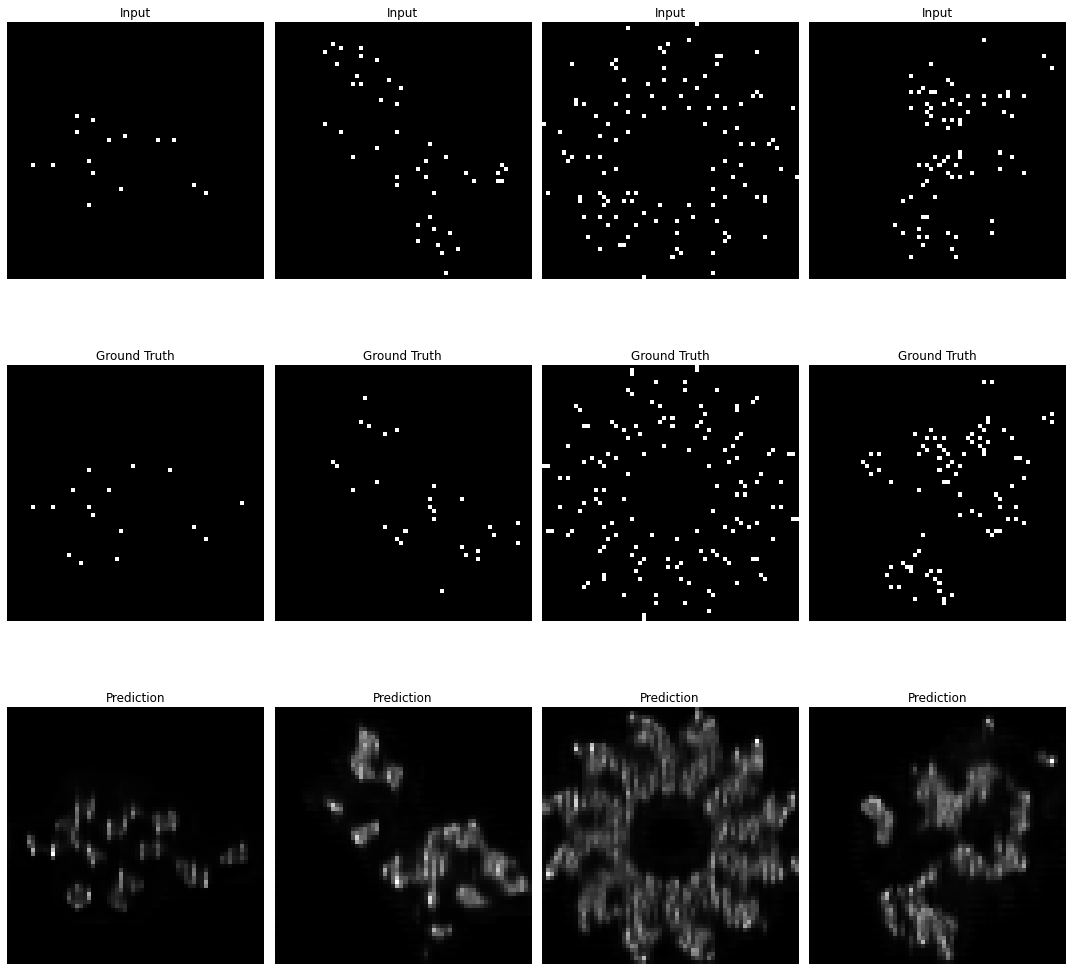

In [17]:
# Visualize the input data, ground truth, and predictions
# Example visualization code (modify as needed)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))

for i in range(4):
    axes[0, i].imshow(inputs_array[i, 0, :, :, 32], cmap='gray')  # Show the input slice
    axes[0, i].set_title('Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(ground_truth_array[i, :, :, 32], cmap='gray')  # Show the ground truth slice
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    axes[2, i].imshow(predictions_array[i, 0, :, :, 32], cmap='gray')  # Show the prediction slice
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

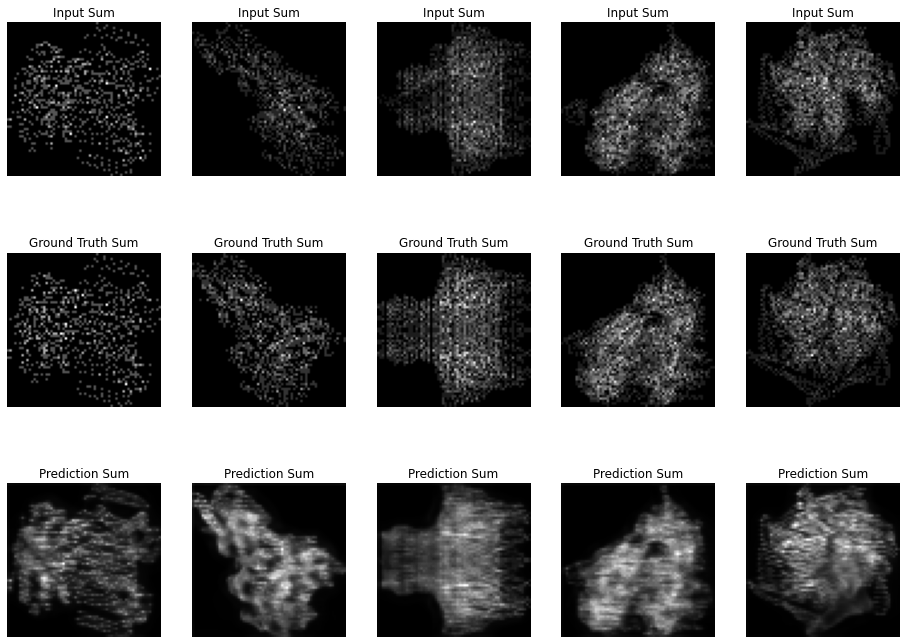

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array, start_layer=0, end_layer=63):
    fig, ax = plt.subplots(3, 5, figsize=(16, 12))

    for i, (input, gt, preds) in enumerate(zip(inputs_array, ground_truth_array, predictions_array)):    
        
        # Perform summation along the depth axis
        input_sum = np.sum(input[0], axis=0)
        true_sum = np.sum(gt, axis=0)
        pred_sum = np.sum(np.sum(preds, axis=0), axis=0)

        # Plot the summed slices
        ax[0, i].imshow(input_sum, cmap='gray')  # Select a slice along the depth axis
        ax[0, i].set_title('Input Sum')
        ax[0, i].axis('off')

        ax[1, i].imshow(true_sum, cmap='gray')  # Select a slice along the depth axis
        ax[1, i].set_title('Ground Truth Sum')
        ax[1, i].axis('off')

        ax[2, i].imshow(pred_sum, cmap='gray')  # Select a slice along the depth axis
        ax[2, i].set_title('Prediction Sum')
        ax[2, i].axis('off')
   
        if i == 4:
            break

    plt.show()
    
# Example usage
plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array)


In [ ]:
### Overfit?

In [ ]:
### Check the training dataset predictions

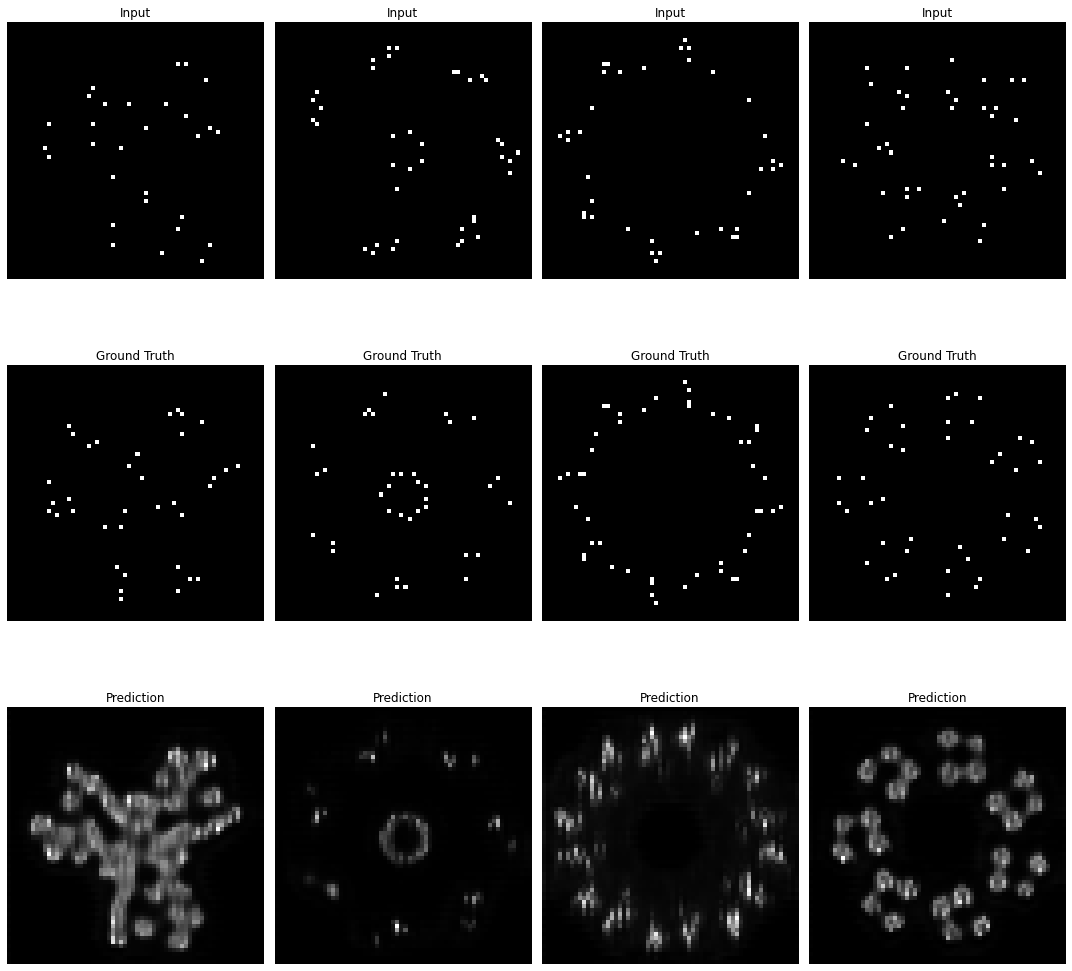

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store inputs, ground truth, and predictions
inputs_list_train = []
predictions_list_train = []
ground_truth_list_train = []

# Iterate over the test data
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        homolog_ca = batch['homolog_ca'].to(device)
        true_vol = batch['true_vol'].to(device)
        true_ca = batch['true_ca'].to(device)

        inputs_train = torch.stack((homolog_ca, true_vol), dim=1)
        
        # Forward pass
        outputs_train = model(inputs_train)

        # Append inputs, ground truth, and predictions to the lists
        inputs_list_train.append(inputs_train.cpu().numpy())
        predictions_list_train.append(outputs_train.cpu().numpy())
        ground_truth_list_train.append(true_ca.cpu().numpy())

        if i == 10:
            break
            
# Convert lists to NumPy arrays
inputs_array_train = np.concatenate(inputs_list_train, axis=0)
predictions_array_train = np.concatenate(predictions_list_train, axis=0)
ground_truth_array_train = np.concatenate(ground_truth_list_train, axis=0)

# Visualize the input data, ground truth, and predictions
# Example visualization code (modify as needed)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))

for i in range(4):
    axes[0, i].imshow(inputs_array_train[i, 0, :, :, 32], cmap='gray')  # Show the input slice
    axes[0, i].set_title('Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(ground_truth_array_train[i, :, :, 32], cmap='gray')  # Show the ground truth slice
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    axes[2, i].imshow(predictions_array_train[i, 0, :, :, 32], cmap='gray')  # Show the prediction slice
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


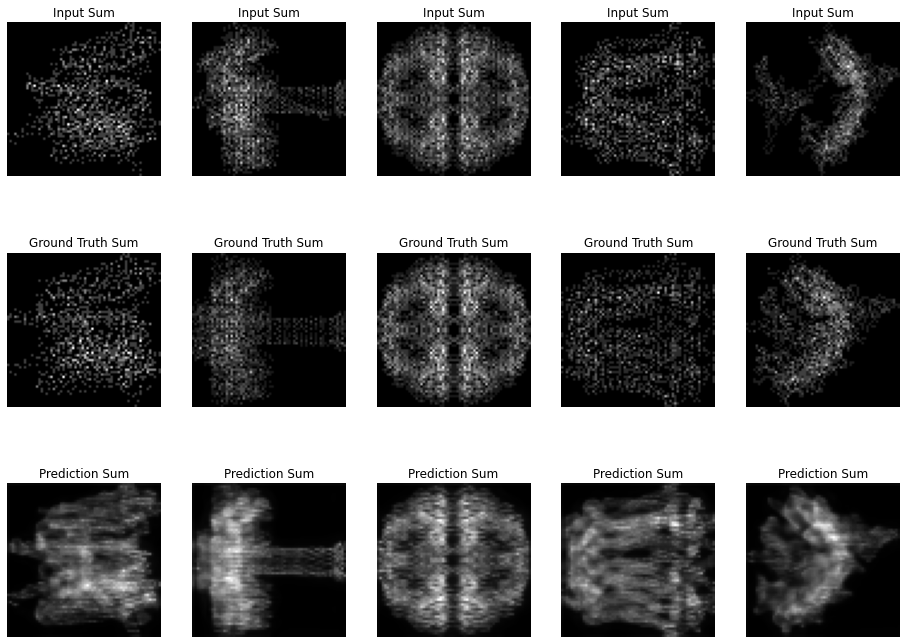

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array, start_layer=0, end_layer=63):
    fig, ax = plt.subplots(3, 5, figsize=(16, 12))

    for i, (input, gt, preds) in enumerate(zip(inputs_array, ground_truth_array, predictions_array)):    
        
        # Perform summation along the depth axis
        input_sum = np.sum(input[0], axis=0)
        true_sum = np.sum(gt, axis=0)
        pred_sum = np.sum(np.sum(preds, axis=0), axis=0)

        # Plot the summed slices
        ax[0, i].imshow(input_sum, cmap='gray')  # Select a slice along the depth axis
        ax[0, i].set_title('Input Sum')
        ax[0, i].axis('off')

        ax[1, i].imshow(true_sum, cmap='gray')  # Select a slice along the depth axis
        ax[1, i].set_title('Ground Truth Sum')
        ax[1, i].axis('off')

        ax[2, i].imshow(pred_sum, cmap='gray')  # Select a slice along the depth axis
        ax[2, i].set_title('Prediction Sum')
        ax[2, i].axis('off')
   
        if i == 4:
            break

    plt.show()
    
# Example usage
plot_slices_with_sum(inputs_array_train, ground_truth_array_train, predictions_array_train)
